In [1]:
import cv2
import pygame
import numpy as np
import time

pygame 2.0.0.dev6 (SDL 2.0.10, python 3.8.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from tello import Tello

In [4]:
# Speed of the drone
S = 60
# Frames per second of the pygame window display
FPS = 25

## Test

In [5]:
tello = Tello()

In [6]:
tello.connect()
tello.set_speed(10)

tello.py - 205 - Send command: command
tello.py - 222 - Response command: ok
tello.py - 205 - Send command: speed 10
tello.py - 222 - Response speed 10: ok


True

In [7]:
tello.streamon()

tello.py - 205 - Send command: streamon
tello.py - 222 - Response streamon: ok


True

In [13]:
tello.takeoff()

tello.send_rc_control(0, 0, S, 0)
time.sleep(2)
tello.send_rc_control(0, 0, 0, 0)
    
frame_read = tello.get_frame_read()
frame = cv2.cvtColor(frame_read.frame, cv2.COLOR_BGR2RGB)
    
tello.land()

tello.py - 205 - Send command: takeoff
tello.py - 212 - Timeout exceed on command takeoff
tello.py - 205 - Send command: takeoff
tello.py - 222 - Response takeoff: ok
tello.py - 254 - Send command (no expect response): rc 0 0 60 0
tello.py - 254 - Send command (no expect response): rc 0 0 0 0
tello.py - 205 - Send command: land
tello.py - 222 - Response land: ok


True

In [8]:
i = 1

In [16]:
frame_read = tello.get_frame_read()
frame = cv2.cvtColor(frame_read.frame, cv2.COLOR_BGR2RGB)

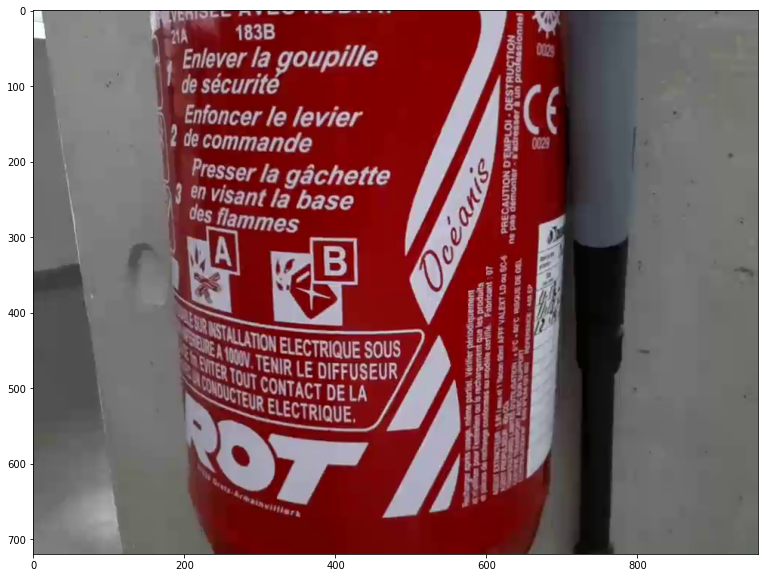

In [17]:
fig = plt.figure(figsize=(20,10))
plt.imshow(frame)

cv2.imwrite('fe.{}.jpg'.format(i), frame)
i += 1

In [7]:
tello.end()

tello.py - 205 - Send command: streamoff
tello.py - 222 - Response streamoff: ok


## Front-end

In [4]:
class FrontEnd(object):
    """ Maintains the Tello display and moves it through the keyboard keys.
        Press escape key to quit.
        The controls are:
            - T: Takeoff
            - L: Land
            - Arrow keys: Forward, backward, left and right.
            - A and D: Counter clockwise and clockwise rotations
            - W and S: Up and down.
    """

    def __init__(self):
        # Init pygame
        pygame.init()

        # Creat pygame window
        pygame.display.set_caption("Tello video stream")
        self.screen = pygame.display.set_mode([960, 720])

        # Init Tello object that interacts with the Tello drone
        self.tello = Tello()

        # Drone velocities between -100~100
        self.for_back_velocity = 0
        self.left_right_velocity = 0
        self.up_down_velocity = 0
        self.yaw_velocity = 0
        self.speed = 10

        self.send_rc_control = False

        # create update timer
        pygame.time.set_timer(pygame.USEREVENT + 1, 50)

    def run(self):

        if not self.tello.connect():
            print("Tello not connected")
            return

        if not self.tello.set_speed(self.speed):
            print("Not set speed to lowest possible")
            return

        # In case streaming is on. This happens when we quit this program without the escape key.
        if not self.tello.streamoff():
            print("Could not stop video stream")
            return

        if not self.tello.streamon():
            print("Could not start video stream")
            return

        frame_read = self.tello.get_frame_read()

        should_stop = False
        while not should_stop:

            for event in pygame.event.get():
                if event.type == pygame.USEREVENT + 1:
                    self.update()
                elif event.type == pygame.QUIT:
                    should_stop = True
                elif event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        should_stop = True
                    else:
                        self.keydown(event.key)
                elif event.type == pygame.KEYUP:
                    self.keyup(event.key)

            if frame_read.stopped:
                frame_read.stop()
                break

            self.screen.fill([0, 0, 0])
            frame = cv2.cvtColor(frame_read.frame, cv2.COLOR_BGR2RGB)
            frame = np.rot90(frame)
            frame = np.flipud(frame)
            frame = pygame.surfarray.make_surface(frame)
            self.screen.blit(frame, (0, 0))
            pygame.display.update()

            time.sleep(1 / FPS)

        # Call it always before finishing. To deallocate resources.
        self.tello.end()

    def keydown(self, key):
        """ Update velocities based on key pressed
        Arguments:
            key: pygame key
        """
        if key == pygame.K_UP:  # set forward velocity
            self.for_back_velocity = S
        elif key == pygame.K_DOWN:  # set backward velocity
            self.for_back_velocity = -S
        elif key == pygame.K_LEFT:  # set left velocity
            self.left_right_velocity = -S
        elif key == pygame.K_RIGHT:  # set right velocity
            self.left_right_velocity = S
        elif key == pygame.K_w:  # set up velocity
            self.up_down_velocity = S
        elif key == pygame.K_s:  # set down velocity
            self.up_down_velocity = -S
        elif key == pygame.K_a:  # set yaw counter clockwise velocity
            self.yaw_velocity = -S
        elif key == pygame.K_d:  # set yaw clockwise velocity
            self.yaw_velocity = S

    def keyup(self, key):
        """ Update velocities based on key released
        Arguments:
            key: pygame key
        """
        if key == pygame.K_UP or key == pygame.K_DOWN:  # set zero forward/backward velocity
            self.for_back_velocity = 0
        elif key == pygame.K_LEFT or key == pygame.K_RIGHT:  # set zero left/right velocity
            self.left_right_velocity = 0
        elif key == pygame.K_w or key == pygame.K_s:  # set zero up/down velocity
            self.up_down_velocity = 0
        elif key == pygame.K_a or key == pygame.K_d:  # set zero yaw velocity
            self.yaw_velocity = 0
        elif key == pygame.K_t:  # takeoff
            self.tello.takeoff()
            self.send_rc_control = True
        elif key == pygame.K_l:  # land
            self.tello.land()
            self.send_rc_control = False

    def update(self):
        """ Update routine. Send velocities to Tello."""
        if self.send_rc_control:
            self.tello.send_rc_control(self.left_right_velocity, self.for_back_velocity, self.up_down_velocity,
                                       self.yaw_velocity)


In [5]:
frontend = FrontEnd()

In [6]:
frontend.run()

tello.py - 205 - Send command: command
tello.py - 222 - Response command: ok
tello.py - 205 - Send command: speed 10
tello.py - 222 - Response speed 10: ok
tello.py - 205 - Send command: streamoff
tello.py - 222 - Response streamoff: ok
tello.py - 205 - Send command: streamon
tello.py - 222 - Response streamon: ok
tello.py - 205 - Send command: takeoff
tello.py - 212 - Timeout exceed on command takeoff
tello.py - 205 - Send command: takeoff
tello.py - 222 - Response takeoff: ok
tello.py - 254 - Send command (no expect response): rc 0 0 0 0
tello.py - 254 - Send command (no expect response): rc 0 0 0 0
tello.py - 254 - Send command (no expect response): rc 0 0 0 0
tello.py - 254 - Send command (no expect response): rc 0 0 0 0
tello.py - 254 - Send command (no expect response): rc 0 0 0 0
tello.py - 254 - Send command (no expect response): rc 0 0 0 0
tello.py - 254 - Send command (no expect response): rc 0 0 0 0
tello.py - 254 - Send command (no expect response): rc 0 0 0 0
tello.py - 25